## Code Modules & Helpful Functions

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl
import tensorflow_hub as th
import tensorflow as tf
import tensorflow.keras.backend as tfkb
from IPython.display import display,HTML
import cv2,PIL.Image
from IPython.core.magic import register_line_magic
from tqdm import tqdm
fpath='../input/image-examples-for-mixed-styles/'

In [2]:
def load_img(path_to_img):
    max_dim=512
    img=tf.io.read_file(path_to_img)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    long_dim=max(shape)
    scale=max_dim/long_dim
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    img=img[tf.newaxis,:]
    return img
def tensor_to_image(tensor):
    tensor=tensor*255
    tensor=np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor=tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
def preprocess(img):
    img=img.copy()
    img=np.expand_dims(img,axis=0) 
    return tf.keras.applications.vgg16\
           .preprocess_input(img)
def deprocess(img):
    img=img.copy()[0]                        
    img[:,:,0]+=103.939
    img[:,:,1]+=116.779
    img[:,:,2]+=123.68             
    img=img[:,:,::-1]              
    img=np.clip(img,0,255)         
    return img.astype('uint8') 

In [4]:
def inputs(original_img,style_img):
    original_img=original_img.astype('float32')
    style_img=style_img.astype('float32')
    original_input=tf.constant(preprocess(original_img))
    style_input=tf.constant(preprocess(style_img))
    generated_input=tf.compat.v1\
    .placeholder(tf.float32,original_input.shape)
    return original_input,style_input,generated_input
def calculate_original_loss(layer_dict,original_layer_names):
    loss=0
    for name in original_layer_names:
        layer=layer_dict[name]
        original_features=layer.output[0,:,:,:]  
        generated_features=layer.output[2,:,:,:] 
        loss+=tfkb.sum(tfkb.square(generated_features-original_features))
    return loss/len(original_layer_names)
def gram_matrix(x):    
    features=tfkb.batch_flatten(tfkb.permute_dimensions(x,(2,0,1))) 
    gram=tfkb.dot(features,tfkb.transpose(features))
    return gram
def get_style_loss(style_features,generated_features,size):
    S=gram_matrix(style_features)
    G=gram_matrix(generated_features)
    channels=3
    return tfkb.sum(tfkb.square(S-G))/(4.*(channels**2)*(size**2))
def calculate_style_loss(layer_dict,style_layer_names,size):
    loss=0
    for name in style_layer_names:
        layer=layer_dict[name]
        style_features=layer.output[1,:,:,:] 
        generated_features=layer.output[2,:,:,:] 
        loss+=get_style_loss(style_features,generated_features,size) 
    return loss/len(style_layer_names)
def calculate_variation_loss(x):
    row_diff=tfkb.square(x[:,:-1,:-1,:]-x[:,1:,:-1,:])
    col_diff=tfkb.square(x[:,:-1,:-1,:]-x[:,:-1,1:,:])
    return tfkb.sum(tfkb.pow(row_diff+col_diff,1.25))

In [5]:
@register_line_magic
def display_img(s):
    imgs=[picture01,pattern01]
    pl.figure(1,figsize=(10,4))
    pl.subplot(121)
    pl.imshow(cv2.cvtColor(
        imgs[0],cv2.COLOR_BGR2RGB))
    pl.subplot(122)
    pl.imshow(cv2.cvtColor(
        imgs[1],cv2.COLOR_BGR2RGB));

## Hub Modules

In [6]:
hpath='https://tfhub.dev/google/magenta/'+\
      'arbitrary-image-stylization-v1-256/1'
hub_module=th.load(hpath)

In [7]:
@register_line_magic
def hm_run(pars):
    pars=pars.split()
    content_image=load_img(fpath+'pattern'+pars[0]+'.png')
    style_image=load_img(fpath+'pattern'+pars[1]+'.png')
    imgs=[content_image,style_image]
    pl.figure(1,figsize=(10,4))
    pl.subplot(121)
    pl.imshow(np.squeeze(imgs[0].numpy()))
    pl.subplot(122)
    pl.imshow(np.squeeze(imgs[1].numpy()))
    stylized_image=hub_module(tf.constant(content_image),
                              tf.constant(style_image))[0]
    display(tensor_to_image(stylized_image))

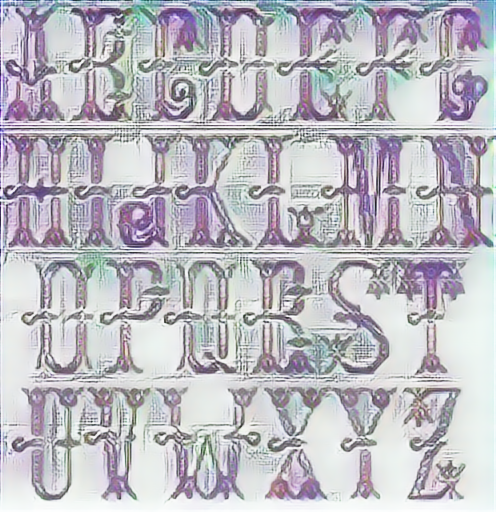

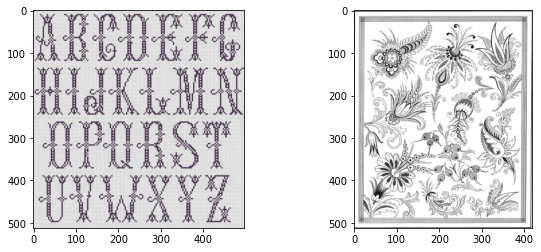

In [8]:
%hm_run 10 05

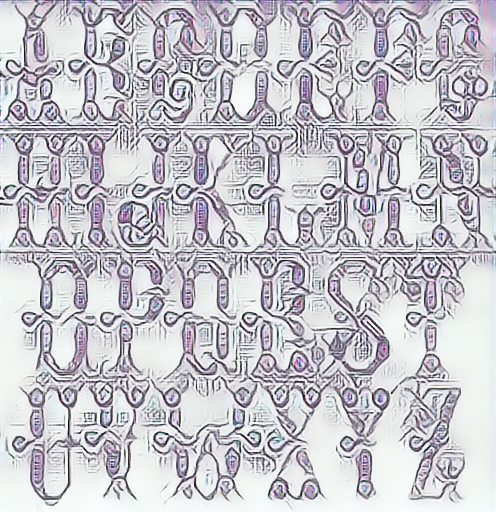

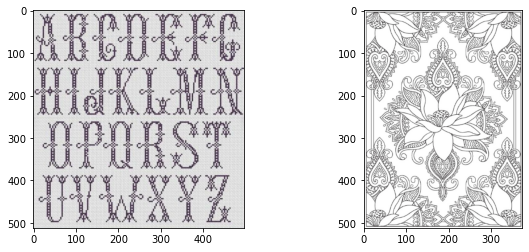

In [9]:
%hm_run 10 06

## VGG16 Transfer

In [10]:
picture01=cv2.imread(fpath+'pattern10.png')
pattern01=cv2.imread(fpath+'pattern03.png')
picture01=cv2.resize(picture01,(500,500))
pattern01=cv2.resize(pattern01,(500,500))
picture01.shape,pattern01.shape,\
picture01.dtype,pattern01.dtype

((500, 500, 3), (500, 500, 3), dtype('uint8'), dtype('uint8'))

In [11]:
style_layers=['block1_conv1','block2_conv1','block3_conv1',
              'block4_conv1','block5_conv1']
@register_line_magic
def train_run(pars):
    pars=pars.split()
    epochs=int(pars[0]); ol=float(pars[1])
    sl=float(pars[2]); vl=float(pars[3])
    sh=pattern01.shape[0]*pattern01.shape[1]
    with tf.Graph().as_default():
        original_input,style_input,generated_input=\
        inputs(picture01,pattern01)
        input_tensor=tf.concat([original_input,style_input,
                                generated_input],axis=0)
        print(input_tensor.shape)
        vgg16_model=tf.keras.applications.vgg16.\
        VGG16(input_tensor=input_tensor,include_top=False)
        vgg16_layer_dict={layer.name:layer 
                          for layer in vgg16_model.layers}
        original_loss=\
        calculate_original_loss(vgg16_layer_dict,
                                ['block5_conv2'])
        style_loss=\
        calculate_style_loss(vgg16_layer_dict,style_layers,sh)
        variation_loss=\
        calculate_variation_loss(generated_input)
        loss=ol*original_loss+sl*style_loss+vl*variation_loss       
        gradients=tfkb.gradients(loss,generated_input)[0]
        calculate=tfkb.function([generated_input],
                                [loss,gradients])
        generated_data=preprocess(picture01)
        for i in tqdm(range(epochs)):
            _,gradients_value=calculate([generated_data])
            generated_data-=gradients_value*.001
    generated_image=deprocess(generated_data)
    pl.figure(1,figsize=(8,8))
    pl.title("loss: %.1f*original_loss+%.1f*style_loss+"%(ol,sl)+\
             "%.1f*variation_loss => %d steps"%(vl,epochs))
    pl.imshow(cv2.cvtColor(generated_image,cv2.COLOR_BGR2RGB));

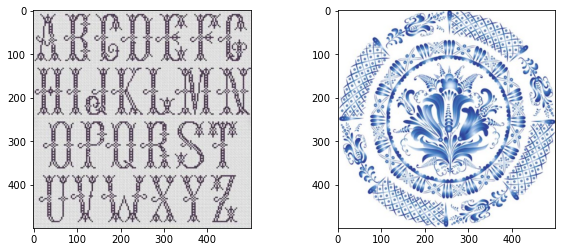

In [12]:
%display_img y

(3, 500, 500, 3)
58892288/58889256 [==============================] - 0s 0us/step


100%|██████████| 100/100 [18:32<00:00, 11.12s/it]


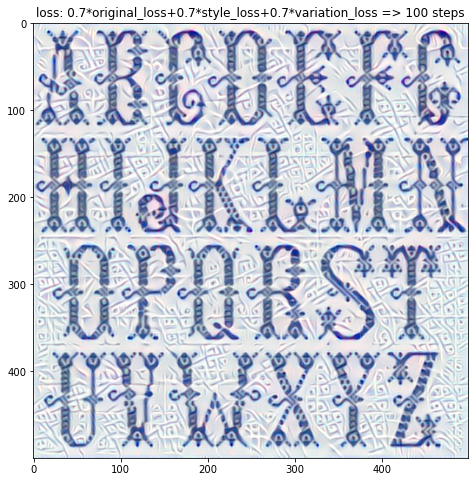

In [13]:
%train_run 100 .7 .7 .7

In [14]:
picture01=cv2.imread(fpath+'pattern10.png')
pattern01=cv2.imread(fpath+'picture03.png')
picture01=cv2.resize(picture01,(500,500))
pattern01=cv2.resize(pattern01,(500,500))

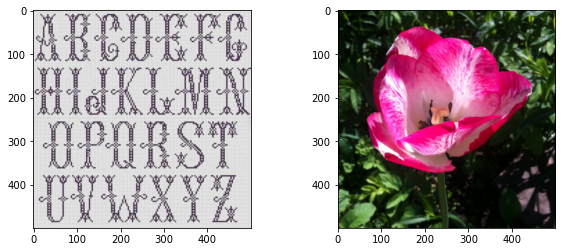

In [15]:
%display_img y

(3, 500, 500, 3)


100%|██████████| 50/50 [09:24<00:00, 11.28s/it]


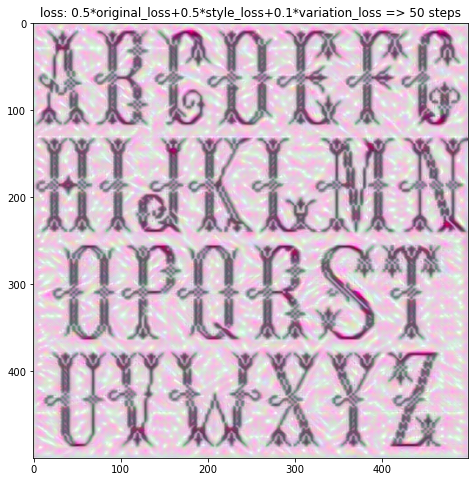

In [16]:
%train_run 50 .5 .5 .1